# TM10007 Assignment ADNI Dataset
Bram Gerritse 4462599  
Saskia Bijl 4439457  
Karan Ramsodit  
Enzo Kerkhof 44488555

### Install git repo:

In [21]:
# Run this to use from colab environment to install git repo
!pip install -q --upgrade git+https://github.com/Enzo-Kerkhof/TM10007_PROJECT.git@Enzo_testing

# Use the @ to determine what branch to install. Don't use to install master.

### Import used libraries

In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn import feature_selection
from sklearn.linear_model import Lasso
from sklearn import neighbors

### Data loading and splitting

In [0]:
# Import premade data loading function
from adni.load_data import load_data

data = load_data()

# Drop labels from dataframe
X = data.drop(['label'],axis=1)

# Binerize labels AD = 1, CN = 0
Y = preprocessing.label_binarize(data['label'], ['CN', 'AD'])
Y = [i[0] for i in Y]

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.5)
y_train = np.array(y_train)

### Missing data handeling

In [0]:
# Features with a lot of zero's?
# Samples with a lot of zero's?



### Feature scaling

Wat is hier de beste optie?

218


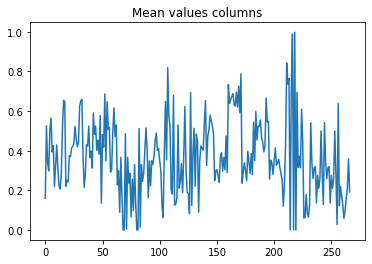

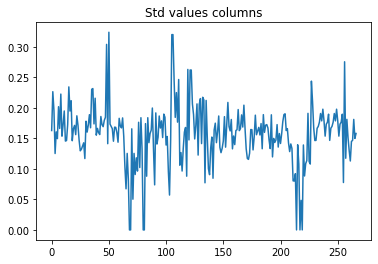

In [24]:
# Scale the data to be normal
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

data_statistics=pd.DataFrame(X_train_scaled).describe()
plt.figure();
plt.plot(range(267),data_statistics.loc['mean',:])
plt.title("Mean values columns")

plt.figure();
plt.plot(range(267),data_statistics.loc['std',:])
plt.title("Std values columns")

print(np.argmax(data_statistics.loc['mean',:]))

### Feature selection

Alleen PCA of eerst selecton én PCA?

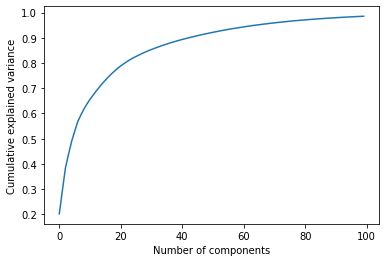

In [25]:
# Perform a PCA
pca = decomposition.PCA(n_components=100)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [26]:


# Now first use the selectfrom model module. Select all features with a weight above the median.
selector = feature_selection.SelectFromModel(estimator=Lasso(alpha=10**(-10)), threshold='median')
selector.fit(X_train_scaled, y_train)
n_original = X_train_scaled.shape[1]
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)
n_selected = X_train_selected.shape[1]
print(f"Selected {n_selected} from {n_original} features.")


X_train = X_train_pca
X_test = X_test_pca

Selected 134 from 267 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.337339792363288, tolerance: 0.01019016393442623
  positive)



### Fit classifier

Hoe ingewikkeld willen we de classifier? Wat past bij onze data?

In [27]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train, y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = y_train[validation_index]
    
    X_validation_test = X_train_pca[test_index]
    y_validation_test = y_train[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(3, 80, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")


# Fit kNN
clf = neighbors.KNeighborsClassifier(n_neighbors=optimal_n)
clf.fit(X_train, y_train)

probabilities_test = clf.predict_proba(X_test)
scores_test = probabilities_test[:, 1]

# Print result
auc = metrics.roc_auc_score(y_test, scores_test)
print(f'THe AUC on the test set is {auc} using a {clf.n_neighbors}-NN classifier')

The optimal N=61
THe AUC on the test set is 0.8492101648351649 using a 61-NN classifier


### Wat is de invloed van de N eigenlijk?

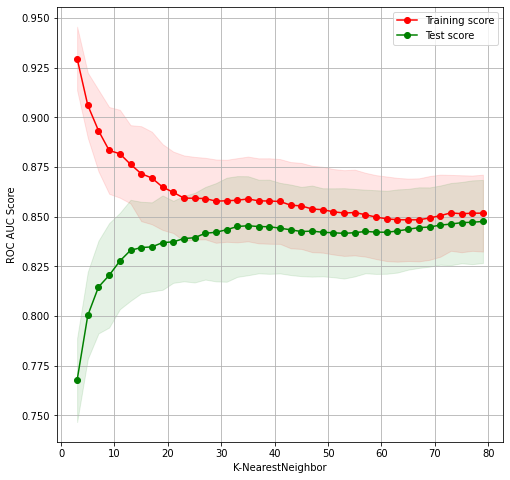

In [28]:
k_list = list(range(3, 80, 2))
all_train = []
all_test = []

# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.5)

for train_index, test_index in sss.split(X_train, y_train):
    train_scores = []
    test_scores = []
    
    split_X_train = X_train[train_index]
    split_y_train = y_train[train_index]
    split_X_test = X_train[test_index]
    split_y_test = y_train[test_index]

    for k in k_list:
        clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        train_proba = clf_knn.predict_proba(split_X_train)[:, 1]
        test_proba = clf_knn.predict_proba(split_X_test)[:, 1]
        
        score_train = metrics.roc_auc_score(split_y_train, train_proba)
        score_test = metrics.roc_auc_score(split_y_test, test_proba)
        

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)
    

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")
ax.set_xlabel('K-NearestNeighbor')
ax.set_ylabel('ROC AUC Score')
ax.legend()